In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')
plt.rc('patch', force_edgecolor=True,edgecolor='black')
plt.rc('hist', bins='auto')

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout

Using TensorFlow backend.


In [4]:
train = pd.read_csv('wrangled_data/training_post_wrangle.csv')

In [5]:
test_full = pd.read_csv('wrangled_data/testing_post_wrangle.csv')

test = test_full.loc[:,['ID', 'shop_id', 'item_id']]

In [6]:
train.shape

(14411682, 12)

In [7]:
test.shape

(214200, 3)

In [8]:
test_full.head()

,ID,shop_id,item_id,month,year,date_block_num,mean_item,mode_item,item_name,item_category_id,item_category_name,shop_name
0,0,5,5037,11,2015,34,0.382353,0.0,5036,19,19,5
1,1,5,5320,11,2015,34,0.000000,0.0,5319,55,55,5
2,2,5,5233,11,2015,34,0.294118,0.0,5232,19,19,5
3,3,5,5232,11,2015,34,0.029412,0.0,5231,23,23,5
4,4,5,5268,11,2015,34,0.000000,0.0,5267,20,20,5


In [9]:
df = pd.merge(test, train, on = ['item_id','shop_id'],how = 'left')
# df = df[df['item_cnt_month'].isna()].loc[:,['ID', 'shop_id', 'item_id']]
# df.reset_index(drop=True, inplace=True)

In [11]:
features = ['date_block_num', 'mean_item', 'mode_item', 'item_name', 'item_category_id', 'item_category_name', 'shop_name']

target = ['item_cnt_month']

values = ['item_cnt_month', 'mean_item', 'mode_item', 'item_name', 'item_category_id', 'item_category_name', 'shop_name']

In [10]:
# df.set_index('ID', inplace=True)
df.head(70)

,ID,shop_id,item_id,year,month,item_cnt_month,date_block_num,mean_item,mode_item,item_name,item_category_id,item_category_name,shop_name
0,0,5,5037,2013.0,2.0,0.0,1.0,0.382353,0.0,5036.0,19.0,19.0,5.0
1,0,5,5037,2013.0,1.0,0.0,0.0,0.382353,0.0,5036.0,19.0,19.0,5.0
2,0,5,5037,2013.0,6.0,0.0,5.0,0.382353,0.0,5036.0,19.0,19.0,5.0
3,0,5,5037,2013.0,3.0,0.0,2.0,0.382353,0.0,5036.0,19.0,19.0,5.0
4,0,5,5037,2013.0,4.0,0.0,3.0,0.382353,0.0,5036.0,19.0,19.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2,5,5233,2015.0,10.0,1.0,33.0,0.294118,0.0,5232.0,19.0,19.0,5.0
66,2,5,5233,2015.0,7.0,0.0,30.0,0.294118,0.0,5232.0,19.0,19.0,5.0
67,2,5,5233,2015.0,9.0,3.0,32.0,0.294118,0.0,5232.0,19.0,19.0,5.0
68,2,5,5233,2015.0,8.0,1.0,31.0,0.294118,0.0,5232.0,19.0,19.0,5.0


In [12]:
dataset = train.pivot_table(index = ['shop_id','item_id'], values = values, columns =['date_block_num'], aggfunc='sum')

In [13]:
dataset.head(3)

item_category_id                                               \
date_block_num              0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0    
shop_id item_id                                                                 
0       30                    40   40   40   40   40   40   40   40   40   40   
        31                    37   37   37   37   37   37   37   37   37   37   
        32                    40   40   40   40   40   40   40   40   40   40   

                 ... shop_name                                               
date_block_num   ...      24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0  
shop_id item_id  ...                                                         
0       30       ...         0    0    0    0    0    0    0    0    0    0  
        31       ...         0    0    0    0    0    0    0    0    0    0  
        32       ...         0    0    0    0    0    0    0    0    0    0  

[3 rows x 238 columns]

In [14]:
dataset.reset_index(inplace = True)

In [15]:
dataset.head(3)

shop_id item_id item_category_id                              \
date_block_num                              0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0   
0                    0      30               40  40  40  40  40  40  40  40   
1                    0      31               37  37  37  37  37  37  37  37   
2                    0      32               40  40  40  40  40  40  40  40   

                ... shop_name                                               
date_block_num  ...      24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0  
0               ...         0    0    0    0    0    0    0    0    0    0  
1               ...         0    0    0    0    0    0    0    0    0    0  
2               ...         0    0    0    0    0    0    0    0    0    0  

[3 rows x 240 columns]

In [16]:
dataset = pd.merge(test, dataset, on = ['item_id','shop_id'], how='left')

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [17]:
dataset.head()

,ID,shop_id,item_id,"(item_category_id, 0.0)","(item_category_id, 1.0)","(item_category_id, 2.0)","(item_category_id, 3.0)","(item_category_id, 4.0)","(item_category_id, 5.0)","(item_category_id, 6.0)",...,"(shop_name, 24.0)","(shop_name, 25.0)","(shop_name, 26.0)","(shop_name, 27.0)","(shop_name, 28.0)","(shop_name, 29.0)","(shop_name, 30.0)","(shop_name, 31.0)","(shop_name, 32.0)","(shop_name, 33.0)"
0,0,5,5037,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,3,5,5232,23.0,23.0,23.0,23.0,23.0,23.0,23.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
dataset.fillna(0,inplace = True)

dataset.head()

,ID,shop_id,item_id,"(item_category_id, 0.0)","(item_category_id, 1.0)","(item_category_id, 2.0)","(item_category_id, 3.0)","(item_category_id, 4.0)","(item_category_id, 5.0)","(item_category_id, 6.0)",...,"(shop_name, 24.0)","(shop_name, 25.0)","(shop_name, 26.0)","(shop_name, 27.0)","(shop_name, 28.0)","(shop_name, 29.0)","(shop_name, 30.0)","(shop_name, 31.0)","(shop_name, 32.0)","(shop_name, 33.0)"
0,0,5,5037,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,3,5,5232,23.0,23.0,23.0,23.0,23.0,23.0,23.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
dataset.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)
dataset.head()

,"(item_category_id, 0.0)","(item_category_id, 1.0)","(item_category_id, 2.0)","(item_category_id, 3.0)","(item_category_id, 4.0)","(item_category_id, 5.0)","(item_category_id, 6.0)","(item_category_id, 7.0)","(item_category_id, 8.0)","(item_category_id, 9.0)",...,"(shop_name, 24.0)","(shop_name, 25.0)","(shop_name, 26.0)","(shop_name, 27.0)","(shop_name, 28.0)","(shop_name, 29.0)","(shop_name, 30.0)","(shop_name, 31.0)","(shop_name, 32.0)","(shop_name, 33.0)"
0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
dataset.shape

(214200, 238)

In [34]:
dataset.columns[60:]

Index([('item_category_name', 26.0), ('item_category_name', 27.0),
       ('item_category_name', 28.0), ('item_category_name', 29.0),
       ('item_category_name', 30.0), ('item_category_name', 31.0),
       ('item_category_name', 32.0), ('item_category_name', 33.0),
            ('item_cnt_month', 0.0),      ('item_cnt_month', 1.0),
       ...
                ('shop_name', 24.0),          ('shop_name', 25.0),
                ('shop_name', 26.0),          ('shop_name', 27.0),
                ('shop_name', 28.0),          ('shop_name', 29.0),
                ('shop_name', 30.0),          ('shop_name', 31.0),
                ('shop_name', 32.0),          ('shop_name', 33.0)],
      dtype='object', length=178)

In [25]:
# X we will keep all columns execpt the last one 
X_train = np.expand_dims(dataset.values[:,:-1],axis = 2)
# the last column is our label
y_train = dataset.values[:,-1:]

# for test we keep all the columns execpt the first one
X_test = np.expand_dims(dataset.values[:,1:],axis = 2)

# lets have a look on the shape 
print(X_train.shape,y_train.shape,X_test.shape)

(214200, 237, 1) (214200, 1) (214200, 237, 1)


In [26]:
# our defining our model 
model_lstm = Sequential()
model_lstm.add(LSTM(units = 64,input_shape = (X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(1))

model_lstm.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [27]:
history_lstm = model_lstm.fit(X_train,y_train,batch_size = 4096,epochs = 10)

Epoch 1/10
214200/214200 [==============================] - 151s 706us/step - loss: 612.3848 - mean_squared_error: 612.3849
Epoch 2/10
214200/214200 [==============================] - 148s 693us/step - loss: 421.2851 - mean_squared_error: 421.2851
Epoch 3/10
214200/214200 [==============================] - 148s 690us/step - loss: 325.6951 - mean_squared_error: 325.6951
Epoch 4/10
214200/214200 [==============================] - 149s 695us/step - loss: 261.8627 - mean_squared_error: 261.8627
Epoch 5/10
214200/214200 [==============================] - 149s 694us/step - loss: 210.0503 - mean_squared_error: 210.0504
Epoch 6/10
214200/214200 [==============================] - 148s 692us/step - loss: 171.7012 - mean_squared_error: 171.7012
Epoch 7/10
214200/214200 [==============================] - 149s 695us/step - loss: 142.7505 - mean_squared_error: 142.7505
Epoch 8/10
214200/214200 [==============================] - 148s 692us/step - loss: 119.4341 - mean_squared_error: 119.4341
Epoch 9/

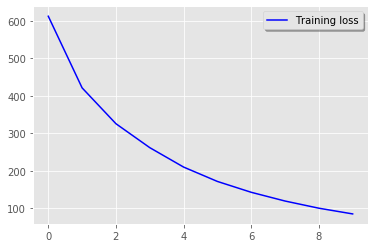

In [28]:
# Plot the loss curves for training
plt.plot(history_lstm.history['loss'], color='b', label="Training loss")
plt.legend(loc='best', shadow=True)

In [29]:
# creating submission file 
submission_pfs = model_lstm.predict(X_test)
# we will keep every value between 0 and 20
submission_pfs = submission_pfs.clip(0,20)
# creating dataframe with required columns 
submission = pd.DataFrame({'ID':test_data['ID'],'item_cnt_month':submission_pfs.ravel()})
# creating csv file from dataframe
submission.to_csv('sub_pfs_no_encoding.csv',index = False)

NameError: name 'test_data' is not defined

In [ ]:
submission.head(3)

In [ ]:
submission.shape, test_data.shape

---
---
---

In [ ]:
items = pd.read_csv('./csv_folder/items.csv')
item_categs = pd.read_csv('./csv_folder/item_categories.csv')
shops = pd.read_csv('./csv_folder/shops.csv')

# Add all item features
df = pd.merge(df, items, how='left', on='item_id')
# Adding item category features
df = pd.merge(df, item_categs, how='left', on='item_category_id')
# Adding shop feature
df = pd.merge(df, shops, how='left', on='shop_id')

In [ ]:
# Label encoding
for c in ['shop_name', 'item_name', 'item_category_name']:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df[c].unique())+list(test[c].unique()))
    df[c]=lbl.transform(train_df[c].astype(str))
    test[c]=lbl.transform(test[c].astype(str))
    print(c)

In [27]:
train.groupby(['shop_id', 'item_category_id'])['item_cnt_month'].agg([np.mean]).reset_index()

,shop_id,item_category_id,mean
0,0,0,0.029412
1,0,1,0.029412
2,0,2,0.128676
3,0,3,1.529412
4,0,4,0.186275
...,...,...,...
3266,59,75,0.386622
3267,59,77,0.029412
3268,59,79,10.147059
3269,59,80,0.294118


In [ ]:
# train['date'] = pd.to_datetime(train[['year', 'month']].assign(DAY=1))

In [ ]:
dataset.reset_index(inplace=True)

In [ ]:
# dataset = pd.merge(test, dataset, how='inner', on=['shop_id', 'item_id'])

dataset = pd.merge(test, dataset,on = ['item_id','shop_id'],how = 'left')

In [ ]:
# train[(train['shop_id']==5) & (train['item_id']==9500)]
train[(train['item_id']==5320)]

In [ ]:
dataset[dataset[('item_category_id', 0.0)].isna()]

In [ ]:
dataset[dataset.isna()]

In [ ]:
dataset.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)
dataset.head()

In [ ]:
np.expand_dims(dataset.values[:,:-1],axis = 2).shape

In [ ]:
test.shape